In [3]:
import xml.etree.ElementTree as ET
def normal(value):
    if value > 180:
        return (value - 360)
    else:
        return value
def extract_coordinates(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    namespace = {
        'isda': 'https://isda.issdc.gov.in/pds4/isda/v1'
    }

    refined_coords = root.find('.//isda:Refined_Corner_Coordinates', namespace)

    def get_coords(element):
        return {
            'upper_left': (float(element.find('isda:upper_left_latitude', namespace).text), float(element.find('isda:upper_left_longitude', namespace).text)),
            'upper_right': (float(element.find('isda:upper_right_latitude', namespace).text), float(element.find('isda:upper_right_longitude', namespace).text)),
            'lower_left': (float(element.find('isda:lower_left_latitude', namespace).text), float(element.find('isda:lower_left_longitude', namespace).text)),
            'lower_right': (float(element.find('isda:lower_right_latitude', namespace).text), float(element.find('isda:lower_right_longitude', namespace).text))
        }

    refined_corner_coordinates = get_coords(refined_coords)
    for x,y in refined_corner_coordinates.items():
        refined_corner_coordinates[x] = (y[0], normal(y[1]))
    return f"{refined_corner_coordinates['lower_right'][1]}, {refined_corner_coordinates['upper_left'][1]},{refined_corner_coordinates['upper_left'][0]},{refined_corner_coordinates['lower_right'][0]}"


# Example usage:
xml_file = r'official/--ch2_tmc_ncn_20240125T0622476078_d_img_d18/data/calibrated/20240125/ch2_tmc_ncn_20240125T0622476078_d_img_d18.xml'
coordinates = extract_coordinates(xml_file) 
print(coordinates)
    


-24.45539500000001, -23.110079999999982,-21.546675,13.216119


In [15]:
333.31307-360, 334.626088-360,-36.501807,8.421932
335.544605, 336.88992,-21.546675,13.216119


(335.544605, 336.88992, -21.546675, 13.216119)

In [31]:
print( 334.626088-360)

-25.37391200000002


In [ ]:
-26.686930000000018, -25.37391200000002, -36.501807,8.421932

In [39]:
import rasterio
from rasterio.enums import Resampling
import cv2
import numpy as np

def resample_image(input_path, output_path, target_shape, target_transform):
    with rasterio.open(input_path) as dataset:
        data = dataset.read(
            out_shape=(
                dataset.count,
                target_shape[0],
                target_shape[1]
            ),
            resampling=Resampling.bilinear
        )
        
        new_transform = dataset.transform * dataset.transform.scale(
            (dataset.width / data.shape[-1]),
            (dataset.height / data.shape[-2])
        )
        
        with rasterio.open(
            output_path,
            'w',
            driver='GTiff',
            height=data.shape[1],
            width=data.shape[2],
            count=dataset.count,
            dtype=data.dtype,
            crs=dataset.crs,
            transform=new_transform,
        ) as dst:
            dst.write(data)

def template_matching(high_res_path, resampled_low_res_path):
    # Read the high resolution image
    with rasterio.open(high_res_path) as high_res:
        high_res_image = high_res.read(1)

    # Read the resampled low resolution image
    with rasterio.open(resampled_low_res_path) as low_res:
        low_res_image = low_res.read(1)

    # Perform template matching
    result = cv2.matchTemplate(high_res_image, low_res_image, cv2.TM_CCOEFF_NORMED)

    # Get the best match position
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    # The max location is the best match
    top_left = max_loc
    bottom_right = (top_left[0] + low_res_image.shape[1], top_left[1] + low_res_image.shape[0])

    return top_left, bottom_right, max_val

def process_images(high_res_path, low_res_path):
    resampled_low_res_path = 'resampled_low_res_image.tif'

    # Get the shape and transform from the high resolution image
    with rasterio.open(high_res_path) as high_res:
        target_shape = high_res.shape
        target_transform = high_res.transform

    # Resample the low resolution image
    resample_image(low_res_path, resampled_low_res_path, target_shape, target_transform)

    # Perform template matching
    top_left, bottom_right, match_value = template_matching(high_res_path, resampled_low_res_path)

    print(f"Best match top-left corner: {top_left}")
    print(f"Best match bottom-right corner: {bottom_right}")
    print(f"Match value: {match_value}")

# Paths to your TIFF files
high_res_path = r'E:\pc\code\python\isro_hackathon\segment_4_2.tif'
low_res_path = r'E:\pc\code\python\isro_hackathon\test_crop.tif'

# Run the process
process_images(high_res_path, low_res_path)


error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\templmatch.cpp:1164: error: (-215:Assertion failed) (depth == CV_8U || depth == CV_32F) && type == _templ.type() && _img.dims() <= 2 in function 'cv::matchTemplate'


<h1>IMPORTANT</h1>

In [29]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # Removes the limit

def crop_tif(input_tif, output_tif, left, upper, right, lower):
    # Open the input TIF file
    with Image.open(input_tif) as img:
        # Define the cropping box
        box = (left, upper, right, lower)
        
        # Crop the image
        cropped_img = img.crop(box)
        
        # Save the cropped image to a new TIF file
        cropped_img.save(output_tif)

    print(f"Cropping complete. Output saved to {output_tif}")

# Example usage
input_tif = r'ch2_tmc_ncn_20200208T0057596133_d_img_m65/data/calibrated/20200208/OUTPUT.tif'
output_tif = 'test_crop.tif'
left, upper, right, lower = 100, 170500, 2800, 179000

crop_tif(input_tif, output_tif, left, upper, right, lower)


Cropping complete. Output saved to test_crop.tif


In [9]:
import rasterio
from rasterio.enums import Resampling

def resample_image(input_path, output_path, scale_factor):
    with rasterio.open(input_path) as dataset:
        # Calculate the new shape by scaling the height and width
        new_height = int(dataset.height * scale_factor)
        new_width = int(dataset.width * scale_factor)
        
        # Read and resample the data
        data = dataset.read(
            out_shape=(
                dataset.count,
                new_height,
                new_width
            ),
            resampling=Resampling.bilinear
        )
        
        # Calculate the new transform matrix
        new_transform = dataset.transform * dataset.transform.scale(
            dataset.width / new_width,
            dataset.height / new_height
        )
        
        # Write the resampled data to the output file
        with rasterio.open(
            output_path,
            'w',
            driver='GTiff',
            height=new_height,
            width=new_width,
            count=dataset.count,
            dtype=data.dtype,  # Use the same data type as the original
            crs=dataset.crs,
            transform=new_transform,
        ) as dst:
            dst.write(data)

# Example usage:
input_path = r'E:\pc\code\python\isro_hackathon\segment_4_2.tif'
output_path = r'E:\pc\code\python\isro_hackathon\resampled_image.tif'
scale_factor = 5  # Increase resolution by 20 times

resample_image(input_path, output_path, scale_factor)


Best match top-left corner: (5776, 2433)
Best match bottom-right corner: (8476, 5033)
Match value: 88744058880.0


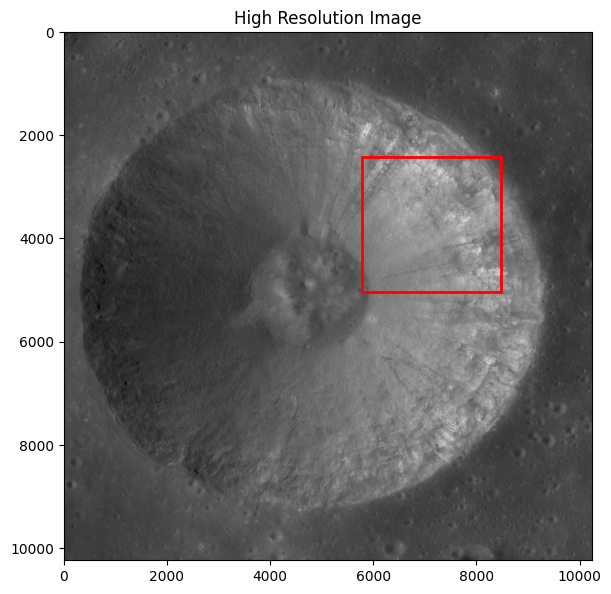

In [7]:
import rasterio
from rasterio.enums import Resampling
import cv2
import numpy as np
import matplotlib.pyplot as plt

# def resample_image(input_path, output_path, target_shape, target_transform):
#     with rasterio.open(input_path) as dataset:
#         data = dataset.read(
#             out_shape=(
#                 dataset.count,
#                 target_shape[0],
#                 target_shape[1]
#             ),
#             resampling=Resampling.bilinear
#         )
        
#         new_transform = dataset.transform * dataset.transform.scale(
#             (dataset.width / data.shape[-1]),
#             (dataset.height / data.shape[-2])
#         )
        
#         with rasterio.open(
#             output_path,
#             'w',
#             driver='GTiff',
#             height=data.shape[1],
#             width=data.shape[2],
#             count=dataset.count,
#             dtype=data.dtype,
#             crs=dataset.crs,
#             transform=new_transform,
#         ) as dst:
#             dst.write(data)

def normalize_image(image):
    """ Normalize the image to uint8 """
    image = image.astype(np.float32)  # Convert to float32
    min_val = np.min(image)
    max_val = np.max(image)
    if max_val > min_val:
        image = (image - min_val) / (max_val - min_val) * 255
    image = image.astype(np.uint8)  # Convert to uint8
    return image

def template_matching(high_res_image, low_res_image):
    # Perform template matching
    result = cv2.matchTemplate(high_res_image, low_res_image, cv2.TM_CCORR, mask=None)

    # Get the best match position
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    # The max location is the best match
    top_left = max_loc
    bottom_right = (top_left[0] + low_res_image.shape[1], top_left[1] + low_res_image.shape[0])

    return top_left, bottom_right, max_val, result

def visualize_results(high_res_path, low_res_path, top_left, bottom_right, result):
    with rasterio.open(high_res_path) as high_res:
        high_res_image = high_res.read(1)
        high_res_image = normalize_image(high_res_image)
    
    with rasterio.open(low_res_path) as low_res:
        low_res_image = low_res.read(1)
        low_res_image = normalize_image(low_res_image)

    # Plot the high resolution image with the matched rectangle
    plt.figure(figsize=(15, 10))
    
    # Display the high resolution image
    plt.subplot(1, 2, 1)
    plt.imshow(high_res_image, cmap='gray')
    plt.title('High Resolution Image')
    plt.gca().add_patch(plt.Rectangle(top_left, low_res_image.shape[1], low_res_image.shape[0], 
                                      edgecolor='red', facecolor='none', linewidth=2))
    

    plt.show()

def process_images(high_res_path, low_res_path):
    resampled_low_res_path = low_res_path

    # # Get the shape and transform from the high resolution image
    # with rasterio.open(high_res_path) as high_res:
    #     target_shape = high_res.shape
    #     target_transform = high_res.transform

    # # Resample the low resolution image
    # resample_image(low_res_path, resampled_low_res_path, target_shape, target_transform)

    # Read and normalize images
    with rasterio.open(high_res_path) as high_res:
        high_res_image = high_res.read(1)
        high_res_image = normalize_image(high_res_image)
    
    with rasterio.open(resampled_low_res_path) as low_res:
        low_res_image = low_res.read(1)
        low_res_image = normalize_image(low_res_image)

    # Perform template matching
    top_left, bottom_right, match_value, result = template_matching(high_res_image, low_res_image)

    print(f"Best match top-left corner: {top_left}")
    print(f"Best match bottom-right corner: {bottom_right}")
    print(f"Match value: {match_value}")

    # Visualize results
    visualize_results(high_res_path, resampled_low_res_path, top_left, bottom_right, result)

# Paths to your TIFF files
high_res_path = r'E:\pc\code\python\isro_hackathon\resampled_low_res_image.tif'
low_res_path = r'E:\pc\code\python\isro_hackathon\test_crop.tif'

# Run the process
process_images(high_res_path, low_res_path)


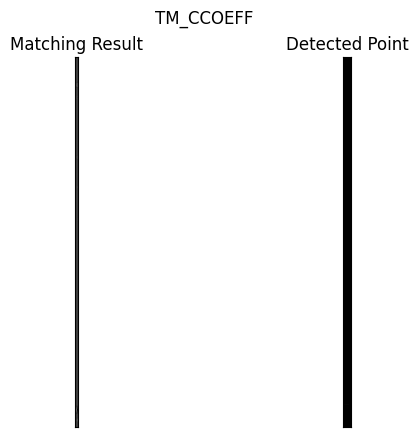

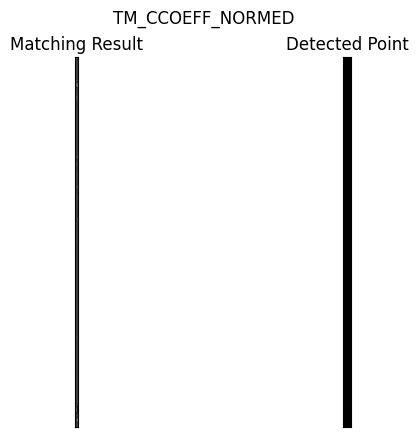

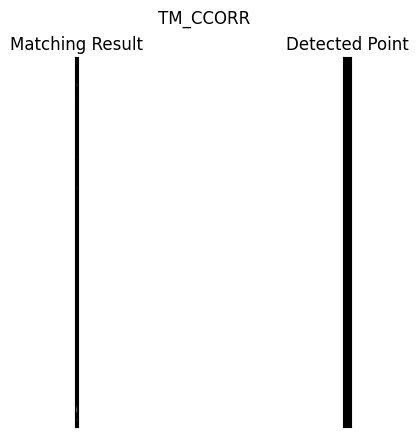

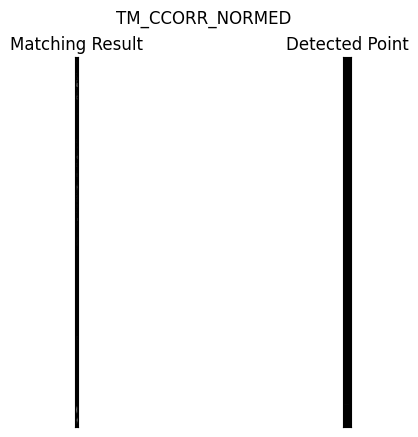

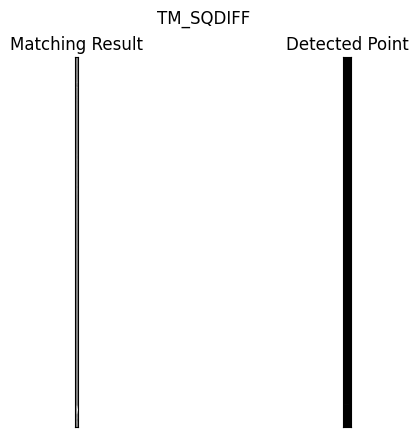

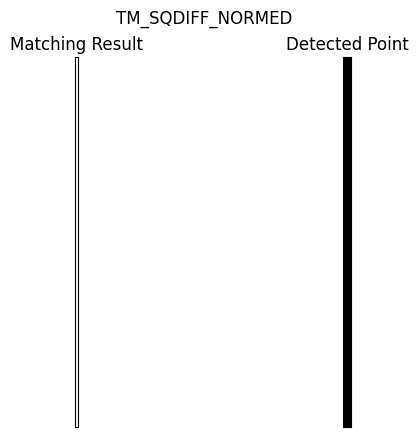

In [8]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
 
img = cv.imread(r'ch2_tmc_ncn_20200208T0057596133_d_img_m65/data/calibrated/20200208/OUTPUT.tif', cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
img2 = img.copy()
template = cv.imread(r'E:\pc\code\python\isro_hackathon\test_crop.tif', cv.IMREAD_GRAYSCALE)
assert template is not None, "file could not be read, check with os.path.exists()"
w, h = template.shape[::-1]
 
# All the 6 methods for comparison in a list
methods = ['TM_CCOEFF', 'TM_CCOEFF_NORMED', 'TM_CCORR',
            'TM_CCORR_NORMED', 'TM_SQDIFF', 'TM_SQDIFF_NORMED']
 
for meth in methods:
    img = img2.copy()
    method = getattr(cv, meth)
 
    # Apply template Matching
    res = cv.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
 
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
 
    cv.rectangle(img,top_left, bottom_right, 255, 5)
 
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
 
    plt.show()